In [61]:
# !rm -rf data/ecgs.zarr
# !./ingest_ecg_records.py

In [158]:
import zarr
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss
from sklearn.neighbors import KernelDensity

# store = zarr.DirectoryStore("data/ecgs.zarr")
# root = zarr.group(store=store, overwrite=False)
# root = zarr.open("data/ecgs.zarr")

root = zarr.open_group("data/ecgs.zarr", mode="r")
root.info

Name,/
Type,zarr.hierarchy.Group
Read-only,True
Store type,zarr.storage.DirectoryStore
No. members,3
No. arrays,0
No. groups,3
Groups,"beats, cleaned, raw"


In [136]:
print(root.tree())

/
 ├── beats
 │   ├── r_peak_idxs (43099,) object
 │   └── valid_r_peak_idxs (43099,) object
 ├── cleaned
 │   └── p_signal (43099,) object
 └── raw
     ├── dx (43099,) object
     ├── meta (43099, 3) int32
     ├── p_signal (43099,) object
     └── p_signal_shape (43099, 2) int32


In [182]:
def get_signal(idx):
    signal = root["raw/p_signal"][idx].reshape(root["raw/p_signal_shape"][idx], order="C")
    cleaned_signal = root["cleaned/p_signal"][idx].reshape(root["raw/p_signal_shape"][idx], order="C")
    age, sex, fs = root["raw/meta"][idx]
    dx = root["raw/dx"][idx]
    
    beats = root["beats/r_peak_idxs"][idx]
    valid_beats = root["beats/valid_r_peak_idxs"][idx]

    beat_windows = root["beats/window_size_400"][idx].reshape(root["beats/window_size_400_shape"][idx], order="C")
    return signal, cleaned_signal, age, sex, fs, dx, beats, valid_beats, beat_windows


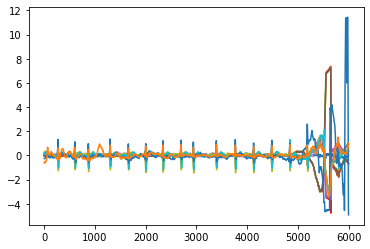

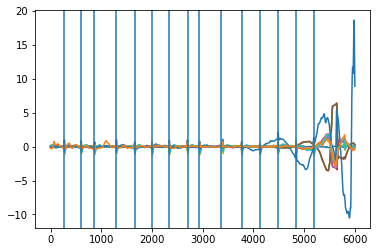

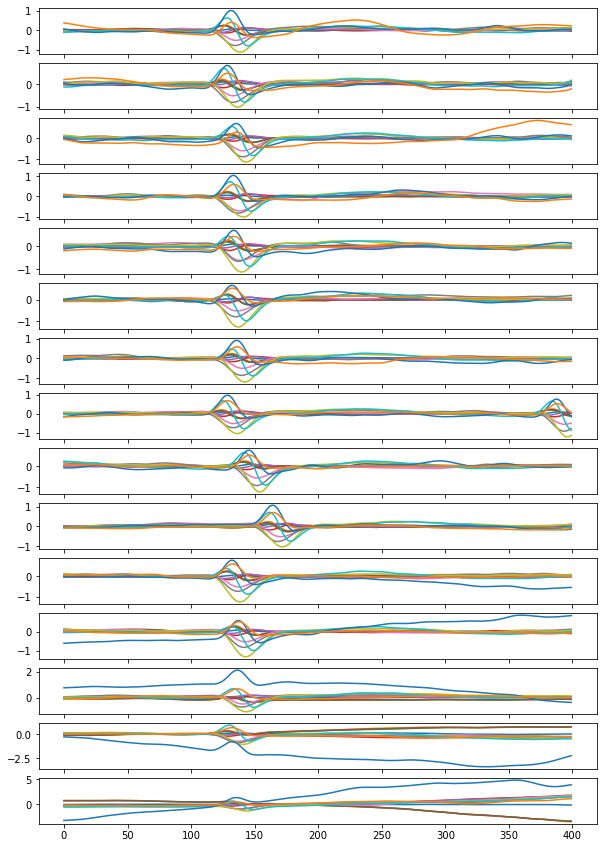

((6000, 12), 72, 0, 500, array([427172004, 164865005], dtype=int32))

In [192]:
(
    signal,
    cleaned_signal,
    age,
    sex,
    fs,
    dx,
    beats,
    valid_beats,
    beat_windows
) = get_signal(7)

plt.plot(signal)
plt.show()
plt.plot(cleaned_signal)
# print(cleaned_signal.shape)
all_r_peaks_flat = np.concatenate(beats)[:, np.newaxis]
sig_range = np.linspace(0, all_r_peaks_flat.max(), len(cleaned_signal))[:, np.newaxis]
for sc in sig_range[valid_beats]:
    plt.axvline(x=sc)
plt.show()
fig, axs = plt.subplots(len(beat_windows), sharex=True, figsize=(10, len(beat_windows)))
for i in range(len(beat_windows)):
    axs[i].plot(beat_windows[i])
    # axs[i].plot(normalize(valid_windows[i].T).T)
plt.show()

signal.shape, age, sex, fs, dx,# beat_windows.shape

## Debugging

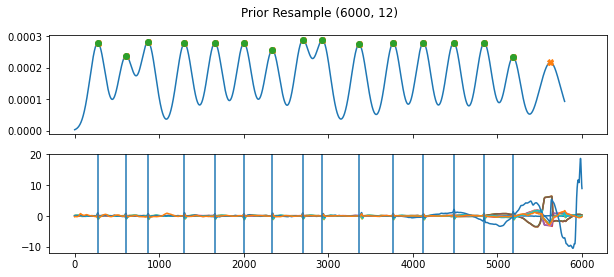

array([[[-5.39018027e-02, -1.21290898e-02,  4.17727381e-02, ...,
         -1.24249108e-01,  1.23724371e-01,  4.07851249e-01],
        [-5.51139414e-02, -1.34485886e-02,  4.16654870e-02, ...,
         -1.22070648e-01,  1.00168623e-01,  4.03952926e-01],
        [-5.62338978e-02, -1.38034066e-02,  4.24306318e-02, ...,
         -1.20123185e-01,  1.14170417e-01,  3.99939895e-01],
        ...,
        [-1.91766825e-02,  4.45258804e-02,  6.37023970e-02, ...,
          1.40113325e-03,  2.77723800e-02,  2.56087363e-01],
        [-1.61435734e-02,  4.88567539e-02,  6.50006905e-02, ...,
          3.36860167e-03,  2.84859221e-02,  2.53285050e-01],
        [-1.28541430e-02,  5.31499833e-02,  6.60040528e-02, ...,
          5.25368284e-03,  3.72071974e-02,  2.50540942e-01]],

       [[-6.48145610e-03,  1.17655443e-02,  1.82472728e-02, ...,
         -1.17051490e-01,  1.50636390e-01,  1.83757961e-01],
        [-2.98906211e-03,  1.39119877e-02,  1.69012658e-02, ...,
         -1.17968947e-01,  1.38310239e

In [193]:
window_size = 400
def _generate_beats(idx):
    p_signal = root["cleaned/p_signal"][idx].reshape(
        root["raw/p_signal_shape"][idx], order="C"
    )
    _, _, fs = root["raw/meta"][idx]
    
    def nk_ecg_peaks(cleaned_signal, sampling_rate=fs):
        try:
            _, ecg_r_peaks_dict = nk.ecg_peaks(
                cleaned_signal,
                sampling_rate=sampling_rate,
                method="neurokit",
                correct_artifacts=True,
            )
            r_peaks = ecg_r_peaks_dict["ECG_R_Peaks"].tolist()
            return r_peaks
        except Exception:
            return []

    all_r_peaks = list(map(nk_ecg_peaks, p_signal.T))

    # Join all of the R-peaks into a single vector
    all_r_peaks_flat = np.concatenate(all_r_peaks)[:, np.newaxis]
    sig_range = np.linspace(0, all_r_peaks_flat.max(), len(p_signal))[:, np.newaxis]

    # Find the peaks with bandwidth proportional to rough mean RR
    rough_meanrr = np.mean(
        [np.diff(r_peaks).mean() for r_peaks in all_r_peaks if len(r_peaks) >= 2]
    )
    kde = KernelDensity(bandwidth=rough_meanrr / 4).fit(all_r_peaks_flat)
    log_dens = kde.score_samples(sig_range)
    dens = np.exp(log_dens)
    peaks, _ = ss.find_peaks(dens)

    # keep only the peaks that are greater than thereshold density
    threshold_peak_density = dens[peaks].mean() - (2 * dens[peaks].std())
    valid_peaks = peaks[dens[peaks] > threshold_peak_density]

    # DISPLAY/DEBUG
    fig, axs = plt.subplots(2, sharex=True, figsize=(10, 4))
    axs[0].plot(sig_range[:, 0], dens)
    axs[0].plot(sig_range[peaks], dens[peaks], "X")
    axs[0].plot(sig_range[valid_peaks], dens[valid_peaks], "o")
    axs[1].plot(p_signal)
    fig.suptitle(f"Prior Resample {p_signal.shape}")
    for vpeak in sig_range[valid_peaks]:
        plt.axvline(x=vpeak)
    plt.show()

#     r_peak_idxs[idx] = all_r_peaks
#     valid_r_peak_idxs[idx] = valid_peaks

    # resample the signal such that the mean distance between
    # valid R-peaks is equal to `window_size`
    scaling_indicies = sig_range[valid_peaks].squeeze()
    scaling_indicies = np.insert(scaling_indicies, 0, 0)
    scaling_indicies = np.append(scaling_indicies, len(p_signal))
    peak_diff_dist = np.diff(scaling_indicies)
    mean_peak_diff_dist = peak_diff_dist.mean()
    resamp_to_len = (len(p_signal) / mean_peak_diff_dist) * window_size
    resamp_to_len = int(np.ceil(resamp_to_len))
    p_signal = ss.resample(p_signal, resamp_to_len)

    # resample the peaks so we don't have to calculate again
    scaling_factor = window_size / mean_peak_diff_dist
    upscaled_peak_diff_dist = peak_diff_dist * scaling_factor
    scaled_indicies = np.r_[scaling_indicies[0], upscaled_peak_diff_dist].cumsum()
    scaled_indicies = scaled_indicies[1:-1]

    # slice up the windows and return the new matrices
    valid_windows = []
    sc_loffset = window_size * 0.35
    for sc in scaled_indicies:
        left_offset = int(np.floor(sc - sc_loffset))
        scaled_window = p_signal[left_offset : left_offset + window_size]
        if len(scaled_window) != window_size:
            # ignore windows that don't fit into window size
            continue
        valid_windows.append(scaled_window)

    valid_windows = np.stack(valid_windows)
#     beat_windows[idx] = valid_windows.flatten(order="C")
#     beat_window_shapes[idx] = valid_windows.shape

    return valid_windows

# _generate_beats(10) # good for figure
_generate_beats(7)